# 線形システムにおけるSystem Level Synthesis

参考：
* [Reinforcement Learning: Theory and Algorithms](https://rltheorybook.github.io/)

[RL_LQR.ipynb](RL_LQR.ipynb)では二次の目的関数と次の線形なシステムを考えました．

$$
x_{t+1}=A x_t+B u_t+w_t, \quad x_0 \sim \mathcal{D}, w_t \sim \mathcal{N}\left(0, \sigma^2 I\right), \quad t \in[0,1, \ldots, H-1]
$$

今回は，次のように一般の凸なコスト関数を考えます．

$$
\mathbb{E}_\pi\left[\sum_{t=0}^{H-1} c_t\left(x_t, u_t\right)\right]
$$

ここで，方策としては時間依存の線形な方策を考えます．つまり，$\left\{-K_t^{\star}\right\}_{t=0}^{H-1}$ with $u_t=-K_t^{\star} x_t$とします．この最適方策の下での総コストは有限とします．

今回は凸のコスト関数なので，もうリッカチ方程式を使うことはできません．
一方で，方策勾配法を使うことで最適な解をみつけることができます．

まず，適当な線形制御器$\left\{-K_t\right\}_{t=0}^{H-1}$を考えましょう．このとき，

$$
\begin{aligned}
u_t=-K_t x_t & =-K_t\left(A x_{t-1}-B K_{t-1} x_{t-1}+w_{t-1}\right) \\
& =-K_t w_{t-1}-K_t\left(A-B K_{t-1}\right) x_{t-1} \\
& =-K_t w_{t-1}-K_t\left(A-B K_{t-1}\right)\left(A x_{t-2}-B K_{t-2} x_{t-2}+w_{t-2}\right) \\
& =\underbrace{-K_t}_{:=M_{t-1 ; t}} w_{t-1} \underbrace{-K_t\left(A-B K_{t-1}\right)}_{:=M_{t-2 ; t}} w_{t-2} \underbrace{-K_t\left(A-B K_{t-1}\right)\left(A-B K_{t-2}\right)}_{:=M_{t-3 ; t}} x_{t-2} \\
& =-K_t\left(\prod_{\tau=1}^t\left(A-B K_{t-\tau}\right)\right) x_0-\sum_{\tau=0}^{t-1} K_t \prod_{h=1}^{t-1-\tau}\left(A-B K_{t-h}\right) w_\tau
\end{aligned}
$$

です．つまり，制御$u_t$を$x_0$と$w_0, \dots, w_{t-1}$で表すことができます．わかりやすく書いてみましょう．

$$
M_t:=-K_t\left(\prod_{\tau=1}^t\left(A-B K_{t-\tau}\right)\right), \quad M_{\tau ; t}:=-K_t \prod_{h=1}^{t-1-\tau}\left(A-B K_{t-h}\right), \text { where } \tau=[0, \ldots, t-1]
$$

とすれば，

$$
u_t=M_t x_0+\sum_{\tau=0}^{t-1} M_{\tau ; t} w_\tau
$$

として表せます．
つまり，次が成立します．

---

任意の制御器$\pi:=\left\{-K_0, \ldots,-K_{H-1}\right\}$に対して，
$\tilde{\pi}$を
$$
\tilde{\pi}:=\left\{\left\{M_t, M_{0 ; t}, \ldots M_{t-1 ; t}\right\}\right\}_{t=0}^{H-1}
$$
とすると，
任意の初期値$x_0$とノイズ$\left\{w_t\right\}_{t=0}^{H-1}$に対して，$\pi$と$\tilde{\pi}$の$x$と$u$の軌跡は同じになります．

---


In [16]:
# 倒立紳士のモデルを使います：https://jp.mathworks.com/help/control/ref/lti.lqr.html
import jax.numpy as jnp
import jax
from typing import NamedTuple


# 有限ホライゾン用です
class MDP(NamedTuple):
    d: int  # 状態の次元
    k: int  # 入力の次元
    H: int  # ホライゾン
    A: jnp.array  # 遷移行列
    B: jnp.array  # 遷移行列
    Q: jnp.array  # コスト行列
    R: jnp.array  # コスト行列
    sigma: float  # ノイズの大きさ


d = 4
k = 1
H = 30
sigma = 0.3
A = jnp.array([
    [0, 1, 0, 0],
    [0, -0.1, 3, 0],
    [0, 0, 0, 1],
    [0, -0.5, 30, 0],
]) * 0.1
A = jnp.repeat(A[None, :, :], H, axis=0)
B = jnp.array([[0,], [2,], [0,], [5,]])
B = jnp.repeat(B[None, :, :], H, axis=0)
Q = jnp.array([
    [1, 0, 0, 0],
    [0, 0, 0, 0],
    [0, 0, 1, 0],
    [0, 0, 0, 0],
])
R = jnp.eye(1)

mdp = MDP(d, k, H, A, B, Q, R, sigma)

In [17]:
import chex


@jax.jit
def compute_P_and_gain(mdp: MDP):
    """MDPについて，リッカチ方程式を複数回走らせてPを計算します．
    また，その結果を利用してゲインも計算します．

    Args:
        mdp (MDP)

    Returns:
        P (jnp.ndarray): (Hxdxd)の行列
        gain (jnp.ndarray): (Hxdxd)の行列
    """
    H, d, _ = mdp.A.shape
    Q, R = mdp.Q, mdp.R

    def backup(i, args):
        P, K = args
        h = H - i - 1

        # まずPを計算します
        P_h1 = P[h+1]
        A_h, B_h = mdp.A[h], mdp.B[h]
        P_h = A_h.T @ P_h1 @ A_h 
        P_h = P_h + Q
        P_h = P_h - A_h.T @ P_h1 @ B_h @ jnp.linalg.inv(B_h.T @ P_h1 @ B_h + R) @ B_h.T @ P_h1 @ A_h
        P = P.at[h].set(P_h)

        # 続いてゲインを計算します
        K_h = jnp.linalg.inv(B_h.T @ P_h1 @ B_h + R) @ B_h.T @ P_h1 @ A_h
        K = K.at[h].set(K_h)
        return P, K
    
    P = jnp.zeros((H+1, d, d))
    K = jnp.zeros((H, k, d))
    P = P.at[H].set(mdp.Q)
    args = P, K
    P, K = jax.lax.fori_loop(0, mdp.H, backup, args)
    return P[:-1], K


In [27]:
import matplotlib.pyplot as plt

# 制御器をダイナミクス上で走らせて得られる価値を観察します
P, K = compute_P_and_gain(mdp)

key = jax.random.PRNGKey(0)
x0 = jax.random.normal(key, (d,))

inputs = []
outputs = []
u_gaps = []
for seed in range(10):
    x = x0.copy()
    xs = []
    us = []
    u_gap = []

    noises = []
    A_BKs = []
    for h in range(H):
        K_h = K[h]
        u = - K_h @ x  # ベースの制御器

        # Mを使って同じ制御を計算します
        M_h = jnp.eye(d)
        sum_M_h = jnp.zeros(d)
        for A_BK, noise in zip(A_BKs, noises):
            sum_M_h = sum_M_h + M_h @ noise
            M_h = M_h @ A_BK 
        uM = - K_h @ (M_h @ x0 + sum_M_h)

        u_gap.append(u - uM)

        xs.append(x[0])
        us.append(u)

        # ダイナミクスを進めます
        key, newkey = jax.random.split(key, 2)
        noise = jax.random.normal(newkey, (d,)) * mdp.sigma
        x = mdp.A[h] @ x + mdp.B[h] @ u + noise

        A_BKs = [mdp.A[h] - mdp.B[h] @ K_h] + A_BKs
        noises = [noise] + noises

    cost = x.T @ mdp.Q @ x
    inputs.append(us)
    outputs.append(xs)
    u_gaps.append(u_gap)

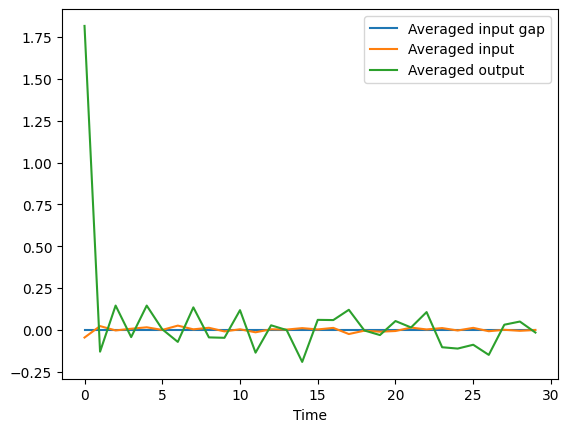

In [28]:
mean_input = jnp.array(inputs).mean(axis=0)
mean_output = jnp.array(outputs).mean(axis=0)
mean_gap = jnp.array(u_gaps).mean(axis=0)

plt.plot(mean_gap, label=f"Averaged input gap")
plt.plot(mean_input, label=f"Averaged input")
plt.plot(mean_output, label=f"Averaged output")
plt.xlabel("Time")
plt.legend()

このように$M$でパラメータ化するメリットは何でしょうか？$\left\{M_t ;\left\{M_{\tau ; t}\right\}_{\tau=0}^{t-1}\right\}$によるパラメータは$t\times d\times k$個のパラメータを持つので，普通のLQRよりもパラメータが増えています．

一方で，このようにパラメータ化すると，$J(\tilde{\pi}):=\mathbb{E}\left[\sum_{t=0}^{H-1} c\left(x_t, u_t\right)\right]$は$\left\{\left\{M_t, M_{0 ; t}, \ldots M_{t-1 ; t}\right\}\right\}_{t=0}^{H-1}$について凸になります．

証明は教科書参照．